# Explore CC
The data challenge set some explicit requirements to fulfill for this dataset:
> * How many months of data do you have?
> * Are there seasonalities over the time? If yes, in which (aggregated) variables? Make some plots.
> * Are there correlations between columns?

I will answer to these questions in the following.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os.path as path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

DATA_PATH = 'DATA'

In [2]:
df=pd.read_csv(path.join(DATA_PATH, 'CC.csv'), sep=';', decimal=',', low_memory=False)

In [3]:
df.head()

,ID_CUSTOMER,ID_RAPPORTO,TIPO_KTO,TIPO_DEBITO,COD_DIVISA,COD_TIP_SALD,DES_TIP_SALD,DAT_RIF_SALD,NUM_AA_MM,IMP_SALD
0,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201501,-5632.53
1,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201502,-5632.53
2,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201503,-5632.53
3,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201504,-5632.53
4,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201505,-5632.53


In [4]:
df.shape

(2233862, 10)

There are no NaN in the dataset:

In [5]:
df.isnull().sum(axis = 0)

ID_CUSTOMER     0
ID_RAPPORTO     0
TIPO_KTO        0
TIPO_DEBITO     0
COD_DIVISA      0
COD_TIP_SALD    0
DES_TIP_SALD    0
DAT_RIF_SALD    0
NUM_AA_MM       0
IMP_SALD        0
dtype: int64

Total number of unique ID_CUSTOMER:

In [6]:
df['ID_CUSTOMER'].unique().shape

(21629,)

Total number of unique ID_RAPPORTO:

In [7]:
df['ID_RAPPORTO'].unique().shape

(43348,)

In [8]:
df['DES_TIP_SALD'].value_counts()

Credito vantato                      912741
Contabile linea capitale             852511
Contabile linea interessi di mora    468610
Name: DES_TIP_SALD, dtype: int64

There are three different types of *SALDO*, but they are not defined in equal number for each ID_RAPPORTO.

Let's pivot the dataset to pass from a long to a wide format.

I make the following assumtion, if one of the three 'DES_TIP_SALD' is not defined for a particular key, I assume it's value is zero.

In [9]:
# Pivot the dataframe, from long to wide:
df_pivot=pd.pivot_table(df, 
                        values='IMP_SALD', 
                        index=['ID_CUSTOMER','ID_RAPPORTO','NUM_AA_MM'], 
                        columns=['DES_TIP_SALD'], 
                        aggfunc=np.sum)

df_pivot.reset_index(inplace=True)

In [10]:
df_pivot.shape

(913362, 6)

In [11]:
df_pivot.isnull().sum(axis = 0)

DES_TIP_SALD
ID_CUSTOMER                               0
ID_RAPPORTO                               0
NUM_AA_MM                                 0
Contabile linea capitale              60851
Contabile linea interessi di mora    444752
Credito vantato                         621
dtype: int64

In [12]:
# In this contest nan represent undefined amount and could be safely replaced by zero.
df_pivot.fillna(0, inplace=True)

In [13]:
df_pivot.head()

DES_TIP_SALD,ID_CUSTOMER,ID_RAPPORTO,NUM_AA_MM,Contabile linea capitale,Contabile linea interessi di mora,Credito vantato
0,1,107945,201501,-1004.51,0.0,-1004.51
1,1,107945,201502,-1004.51,0.0,-1004.51
2,1,107945,201503,-1004.51,0.0,-1004.51
3,1,107945,201504,-1004.51,0.0,-1004.51
4,1,107945,201505,-1004.51,0.0,-1004.51


In [14]:
cols=['Contabile linea capitale', 'Contabile linea interessi di mora', 'Credito vantato']
df_pivot[cols].describe()

DES_TIP_SALD,Contabile linea capitale,Contabile linea interessi di mora,Credito vantato
count,913362.000000,913362.000000,913362.000000
mean,-1074.394893,-218.325532,-1416.094746
std,2749.935438,736.198273,3128.326137
min,-268993.550000,-18798.130000,-284942.260000
25%,-974.630000,-78.760000,-1385.820000
50%,-248.660000,-0.050000,-394.640000
75%,-26.890000,0.000000,-55.800000
max,24355.020000,13452.020000,24355.020000


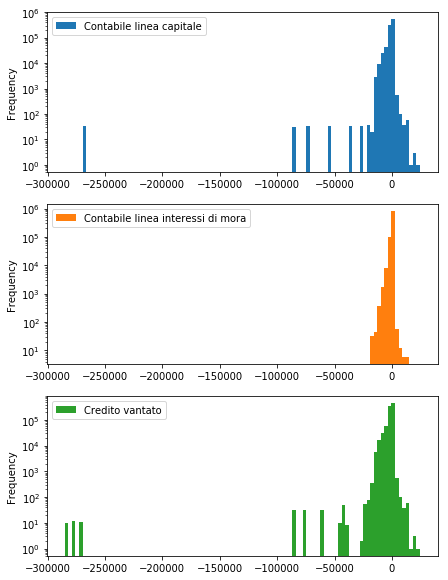

In [15]:
df_pivot[cols].plot.hist(bins=100, logy=True, subplots=True, sharex=False, figsize=(7,10))
plt.show()

The dataset contains some outliers identifyed by very big values in 'Contabile Linea Capitale' and 'Credito Vantato'.

For the sake of this analysis, let's remove the outliers using an arbitrary cut on the z-score:

In [16]:
from scipy import stats
df_pivot_nout=df_pivot[(np.abs(stats.zscore(df_pivot[cols])) < 10).all(axis=1)]

In [17]:
df_pivot.shape

(913362, 6)

In [18]:
df_pivot_nout.shape

(911860, 6)

Remove 1502 outliers (<0.2% of the sample)

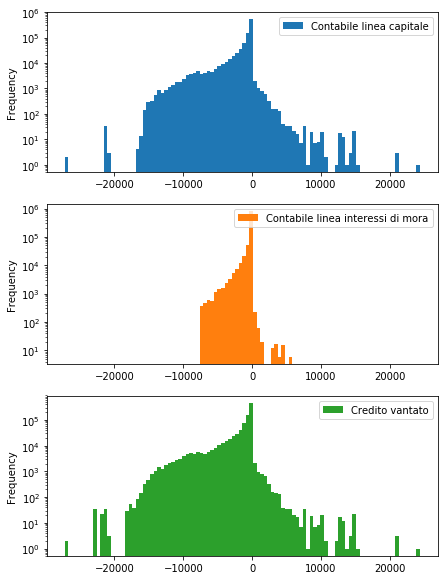

In [19]:
df_pivot_nout[cols].plot.hist(bins=100, logy=True, subplots=True, sharex=False, figsize=(7,10))
plt.show()

## How many month of date do you have?

In [20]:
m=df.groupby('NUM_AA_MM').size()
print('Months of data: %d, from %s to %s' % (
    len(m), 
    pd.to_datetime(m.index[0], format='%Y%m').strftime('%m/%Y'), 
    pd.to_datetime(m.index[-1], format='%Y%m').strftime('%m/%Y')
    ))

Months of data: 33, from 01/2015 to 09/2017


## Are there seasonalities over the time?

In [22]:
# convert the date
df_pivot_nout['NUM_AA_MM'] = pd.to_datetime(df_pivot_nout['NUM_AA_MM'], format='%Y%m')

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Let's build some aggregated variables to look for seasonality:

* Number of ID_CUSTOMER w.r.t. date
* Number of ID_RAPPORTO w.r.t. date
* Total of 'Contabile linea capitale'
* Total of 'Contabile linea interessi di mora'
* Total of 'Credito vantato'


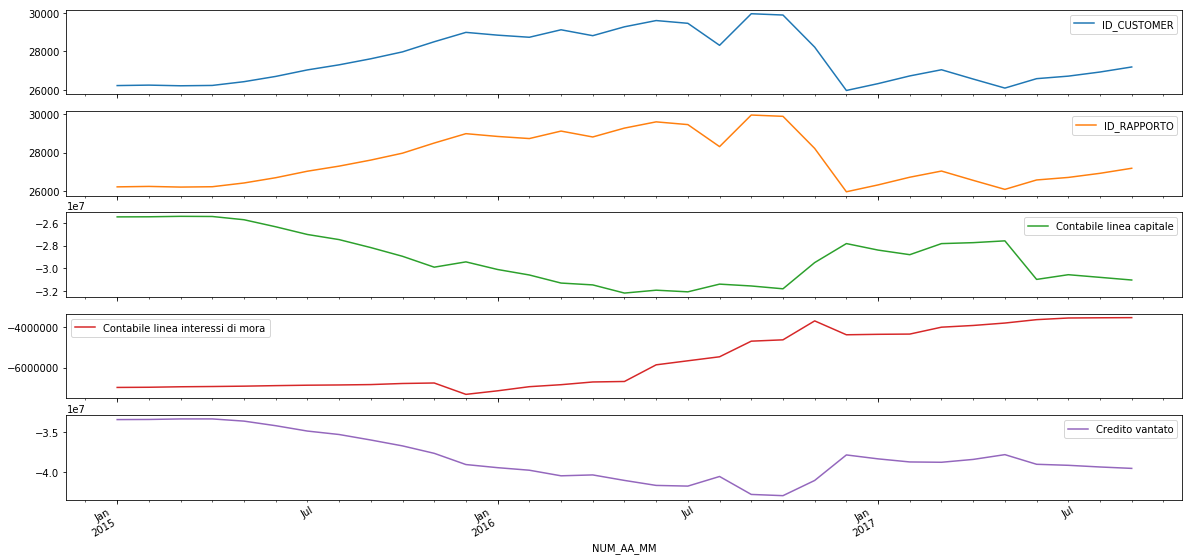

In [23]:
df_agg = df_pivot_nout.groupby('NUM_AA_MM').agg(
    {'ID_CUSTOMER' : 'size'
    , 'ID_RAPPORTO' : 'size'
    ,'Contabile linea capitale' : 'sum'
    ,'Contabile linea interessi di mora' : 'sum'
    ,'Credito vantato' : 'sum'
    })

df_agg.plot(subplots=True, figsize=(20,10))
plt.show()

Looking at the time series by eye, there are no evident seasonalities. Let's check using ACF and PACF functions:

**ACF** is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

**PACF** is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 



In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

def check_ac(ts):
    fig, axes = plt.subplots(1,2, figsize=(20,5))
    plot_acf(ts, lags=30, ax=axes[0])
    plot_pacf(ts, lags=30, ax=axes[1])
    plt.show()

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Check for seasonality in aggregated number of 'ID_CUSTOMER'.

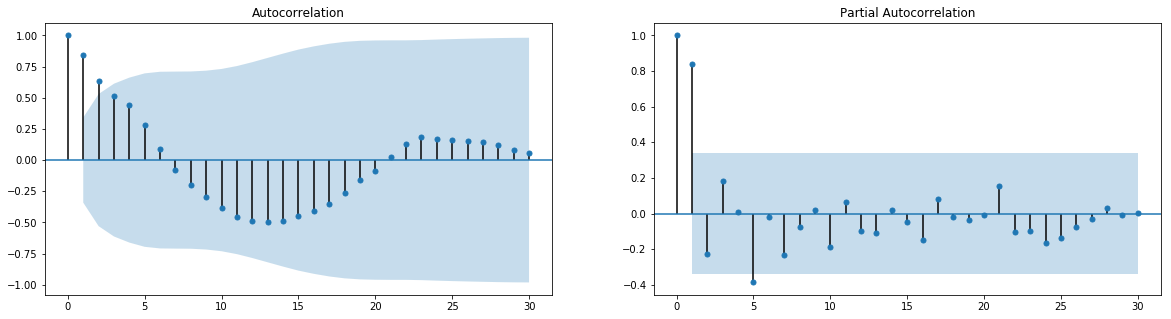

In [25]:
check_ac(df_agg['ID_CUSTOMER'])

### Check for seasonality in the aggregated number of 'ID_RAPPORTO'.

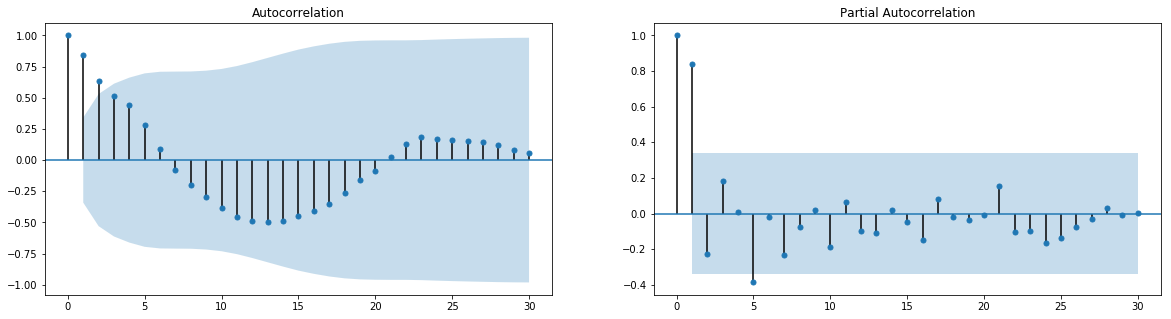

In [26]:
check_ac(df_agg['ID_RAPPORTO'])

### Check for seasonality in aggregated total of 'Contabile linea capitale'.

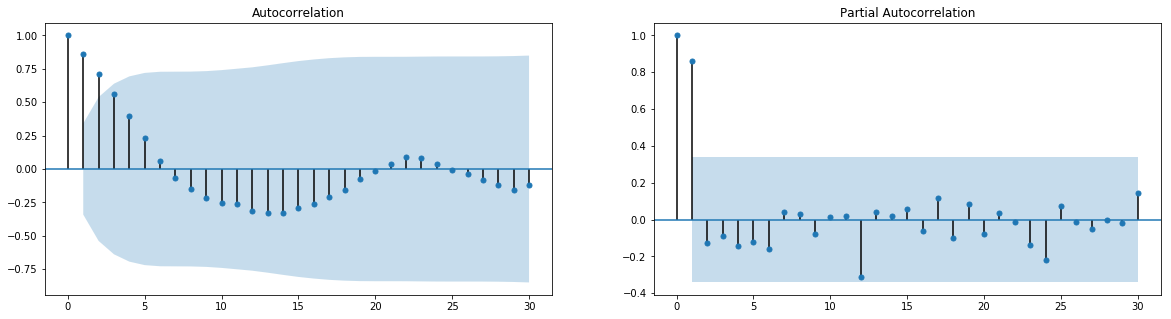

In [27]:
check_ac(df_agg['Contabile linea capitale'])

### Check for seasonality in aggregated total of 'Contabile linea interessi di mora'.

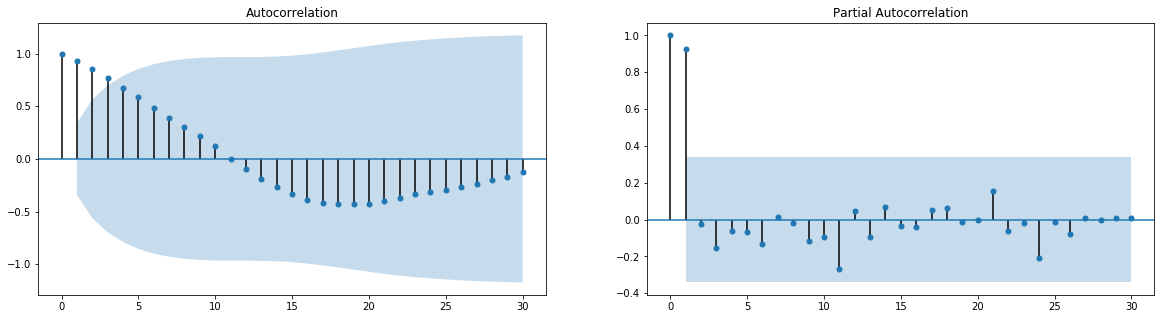

In [28]:
check_ac(df_agg['Contabile linea interessi di mora'])

### Check for seasonality in aggregated total of 'Credito vantato'.

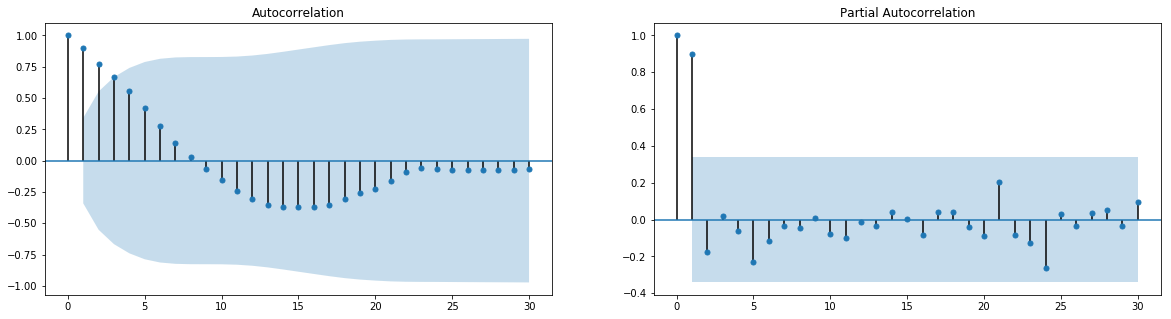

In [29]:
check_ac(df_agg['Credito vantato'])

All observables have statistically significant auto-correlations for lag 1, 2 and 3. The partial auto-correlaiton is statistically significant only for lag 1.  This means that the lag 2 and 3 can be explained by the lag 1 which is the only relevant seasonal component for this dataset.

From a practical point of view, this means that these observables could be forecasted from one month to the next one.

## Are there correlation between columns?

I use the Pearson's correlation to test the presence of linear correlation among columns. the only numerical columns to consider, after pivoting the dataset, are:
1. 'Contabile linea capitale';
2. 'Contabile linea interessi di mora'
3. 'Credito vantato'

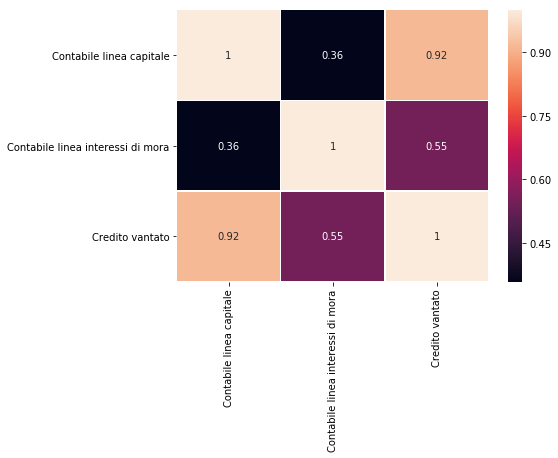

In [29]:
cols=['Contabile linea capitale', 'Contabile linea interessi di mora', 'Credito vantato']
corr=df_pivot_nout[cols].fillna(0).corr()
import seaborn as sns
f, ax = plt.subplots(figsize=(7,5))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)
plt.xlabel('')
plt.ylabel('')
plt.show()

* The matrix above shows clear correlation among these columns;
* The reason should be found in the relationship among these columns;

Credito Vantato ~ Contabile linea capitale + Contabile linea interessi di mora

* The correlations are quite clear looking at the pair plots below;
* The expected relationship among the three features is verified by most of the data point but is not true for all;
* When *Contabile linea capitale* is not equal to 'Credito Vantato', most of the time is bigger;
* *Contabile linea interessi di mora* is expected to be correlated with *Contabile linea capitale*, but the law relating these two features is not clear at this stage (I expect it could also be related to time...);

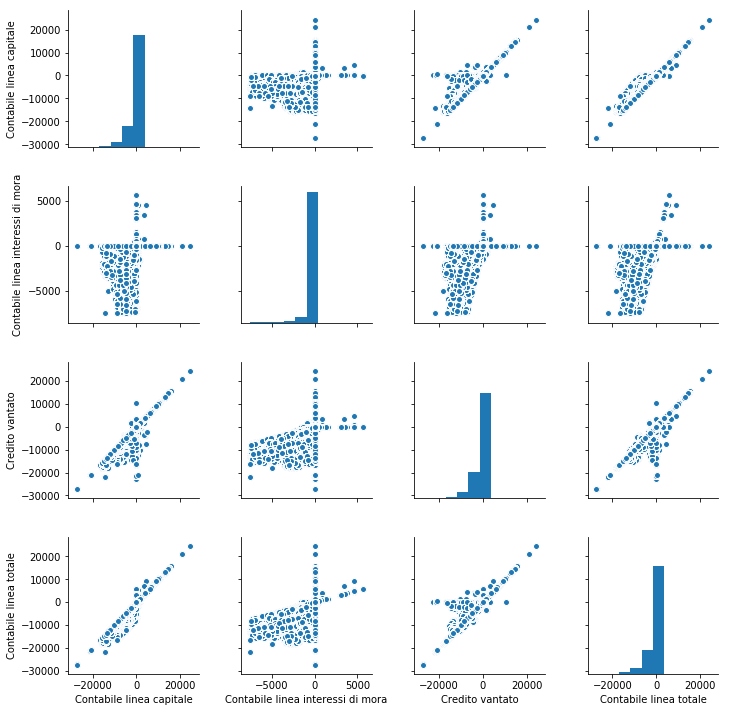

In [30]:
tmp=df_pivot_nout.copy()
tmp['Contabile linea totale'] = tmp['Contabile linea capitale'] + tmp['Contabile linea interessi di mora']

cols= ['Contabile linea capitale',
       'Contabile linea interessi di mora',
       'Credito vantato',
       'Contabile linea totale']

sns.pairplot(tmp[cols].fillna(0))
plt.show()